In [21]:
%matplotlib inline
import pandas as pd
import cycluster as cy
import os.path as op
import numpy as np
import palettable
from custom_legends import colorLegend
import seaborn as sns
from hclusterplot import *
import matplotlib.pyplot as plt
import pprint
import openpyxl
from plotnine import *
# import preprocessing as prep
import scipy.cluster.hierarchy as sch
from matplotlib import cm
from matplotlib.gridspec import GridSpec
import sklearn
import matplotlib as mpl
import itertools
from scipy.spatial import distance
import os
import plotting as plot
import matplotlib.patches as mpatches
from texttable import Texttable

In [22]:
path = "./"
inf = "/Users/NBrah/PycharmProjects/St_Jude/Cycluster"
file = op.join(path,inf)
os.chdir(file)

cwd = os.getcwd()
print(cwd)

C:\Users\NBrah\PycharmProjects\St_Jude\Cycluster


In [24]:
sns.set_context('paper')
path = "./"
inf = "Flu09 NW Data.csv"
dataFilename = op.join(path,inf)
"""A long df has one analyte measurement per row"""
longDf = pd.read_csv(dataFilename)
path_1 = './'
inf_1 = 'Demographics.csv'
dataFilename_1 = op.join(path_1,inf_1)
demographics = pd.read_csv(dataFilename_1)
# demo = demographics.pivot_table(index=['ID', 'Strain'])
# print(demo)
# print(demographics.Strain.isin(['A (pH1)']).values)
demo_list = []
for i in range(len(demographics.Strain.isin(['B']).values)):
    if demographics.Strain.isin(['B']).values[i] == True:
        demo_list += [demographics.ID[i]]
# print(demo_list)
longDf = longDf.drop(columns= ['SJ', 'Season', 'Type'])
# longDf = longDf.loc[longDf.Sample.isin(demo_list)]
longDf = longDf.loc[longDf.Day.isin([0])]
longDf = longDf.drop(columns= ['Day'])
Df = longDf.pivot_table(index='Sample')
# print(Df)


# print(longDf.loc[longDf.Day.isin([0])])

LogDf = Df.apply(func=np.log,axis=0)
# LogDf.to_excel('Ontologix_Test.xlsx')
print(LogDf)

             EGF   Eotaxin      FGF2       FKN  Flt3 Ligand      GCSF  \
Sample                                                                  
1001    4.902753  3.371082  3.858833  6.230973     1.867176  4.967171   
1002    3.376905  3.938275  1.912501  2.436241     1.153732  0.494696   
1003    2.137710  1.826161  1.912501  2.173615     1.153732  1.508512   
1004    4.153085  3.125444  3.858833  4.883786     2.738256  8.405179   
1005    3.093766  0.810930  1.432701  2.955951     1.144223  0.951658   
1006    2.445819  1.826161  1.912501  2.839078     1.752672  0.494696   
1007    4.496582  1.826161  1.912501  3.570377     1.697449  2.589267   
1008    1.599388  0.810930  1.432701  2.844328     1.144223  2.488234   
1009    3.308717  1.826161  1.912501  2.998728     1.637053  2.728506   
1010    2.142416  1.826161  1.912501  2.173615     1.153732  0.494696   
1011    2.065596  0.810930  2.070653  2.883123     1.175573  3.408173   
1012    3.091497  1.826161  1.912501  3.524889     

In [25]:
def meanSubNormalize(cyDf, cyVars=None, compCommVars=None, meanVar=None):
    """Normalize cytokine columns by the log-mean for each patient, within each compartment.
    The point is that if cytokine concentrations are generally high for one sample or another,
    this might dominate the covariation of cytokines across patients (both within/across compartments).

    We subtract off the mean since the "overall inflamation" level
    that we are adjusting for would probably be on the fold-change concentration scale.
    (additive on the log-concentration scale)"""
    def _normFuncSub(vec):
        out = vec - muVec
        return out

    if cyVars is None:
        cyVars = cyDf.columns
    if meanVar is None:
        meanVar = 'Mean'
    if compCommVars is None:
        cyDf.columns

    """No standardizing cytokines before taking the mean (need units to stay in log-concentration)"""
    muVec = cyDf[cyDf.columns].mean(axis=1)
    
    ndf = cyDf.copy()
    ndf.loc[:, cyDf.columns] = ndf[cyDf.columns].apply(_normFuncSub)
    ndf.loc[:, meanVar] = muVec
    return ndf



# Df_values = longDf.drop(columns="Sample")
# Df_values = Df_values.drop(columns="GRO")
# print(Df_values)
# muVec = Df_values[Df_values.columns].mean(axis=1)
# print(Df_values[Df_values.columns])
# print(muVec)
# print(Df_values.isnull().sum())
df_prep = meanSubNormalize(LogDf)
df_prep = df_prep.drop(columns = "Mean")
print(df_prep)

             EGF   Eotaxin      FGF2       FKN  Flt3 Ligand      GCSF  \
Sample                                                                  
1001    1.985139  0.453468  0.941219  3.313359    -1.050438  2.049557   
1002    2.216882  2.778253  0.752479  1.276219    -0.006291 -0.665326   
1003    1.035630  0.724081  0.810421  1.071535     0.051652  0.406432   
1004    0.353858 -0.673783  0.059606  1.084559    -1.060971  4.605953   
1005    2.164013 -0.118823  0.502947  2.026198     0.214470  0.021905   
1006    1.203468  0.583810  0.670150  1.596727     0.510321 -0.747655   
1007    2.776704  0.106283  0.192623  1.850500    -0.022429  0.869389   
1008    0.420587 -0.367870  0.253900  1.665527    -0.034578  1.309434   
1009    1.876386  0.393830  0.480170  1.566397     0.204722  1.296175   
1010    1.058577  0.742321  0.828661  1.089775     0.069892 -0.589143   
1011    0.955680 -0.298986  0.960737  1.773207     0.065657  2.298257   
1012    1.761522  0.496186  0.582527  2.194914     

In [26]:
cwd = os.getcwd()
print(cwd)
path = "./"
inf = "/Users/NBrah/PycharmProjects/St_Jude/Cycluster/Flu09"
file = op.join(path,inf)
os.chdir(file)
cwd = os.getcwd()
print(cwd)

C:\Users\NBrah\PycharmProjects\St_Jude\Cycluster
C:\Users\NBrah\PycharmProjects\St_Jude\Cycluster\Flu09


All1
IL7
TGFa

All2
IL15
PDGFABBB
sCD40L

All3
IL1b
IL6
MIP1a
MIP1b
RANTES
TNFa
VEGF

All4
Flt3 Ligand
GMCSF
IFNg
IL12p40
IL12p70
IL13
IL17A
IL2
IL3
IL4
IL5
IL9
MCP3
TNFb

All5
EGF
FKN
GCSF
IL1Ra2
IL1a
IL8
MCP1
PDGFAA

All6
Eotaxin
FGF2
IFNa2
IL10
MDC



C:\Users\NBrah\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\__init__.py:1855: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


[-0.16394038  0.41362706  0.62205231  0.83292655  0.86507357  0.91427158
  1.04323707  1.14176054  1.26241494  1.30784449  1.35966486  1.41620266
  1.44950135  1.48571459  1.53489243  1.57712237  1.63735379  1.68406376
  1.74790494  1.8098878   1.86807598  1.93380147  2.00592997  2.09060753
  2.17762321  2.1852378   2.26429009  2.3831085   2.46224046  2.52663095]
All1
IL15
TGFa

All2
IL7
PDGFABBB
sCD40L

All3
IL1b
IL6
MIP1a
MIP1b
RANTES
TNFa
VEGF

All4
Flt3 Ligand
GMCSF
IFNg
IL12p40
IL12p70
IL13
IL17A
IL2
IL3
IL4
IL5
IL9
MCP3
TNFb

All5
EGF
FKN
GCSF
IL1Ra2
IL1a
IL8
MCP1
PDGFAA

All6
IFNa2
IL10

All7
Eotaxin
FGF2
MDC

All1
IL15
TGFa

All2
IL7
PDGFABBB
sCD40L

All3
IL1b
IL6
MIP1a
MIP1b
RANTES
TNFa
VEGF

All4
IFNg
IL12p40
IL13
IL3
IL4
MCP3

All5
Flt3 Ligand
GMCSF
IL12p70
IL17A
IL2
IL5
IL9
TNFb

All6
EGF
FKN
GCSF
IL1Ra2
IL1a
IL8
MCP1
PDGFAA

All7
IFNa2
IL10

All8
Eotaxin
FGF2
MDC

All1
IL7
PDGFABBB
sCD40L

All2
IL1b
IL6
MIP1a
MIP1b
RANTES
TNFa
VEGF

All3
IFNg
IL12p40
IL13
IL3
IL4
MCP3

All

<Figure size 1440x1080 with 0 Axes>

<Figure size 864x720 with 0 Axes>

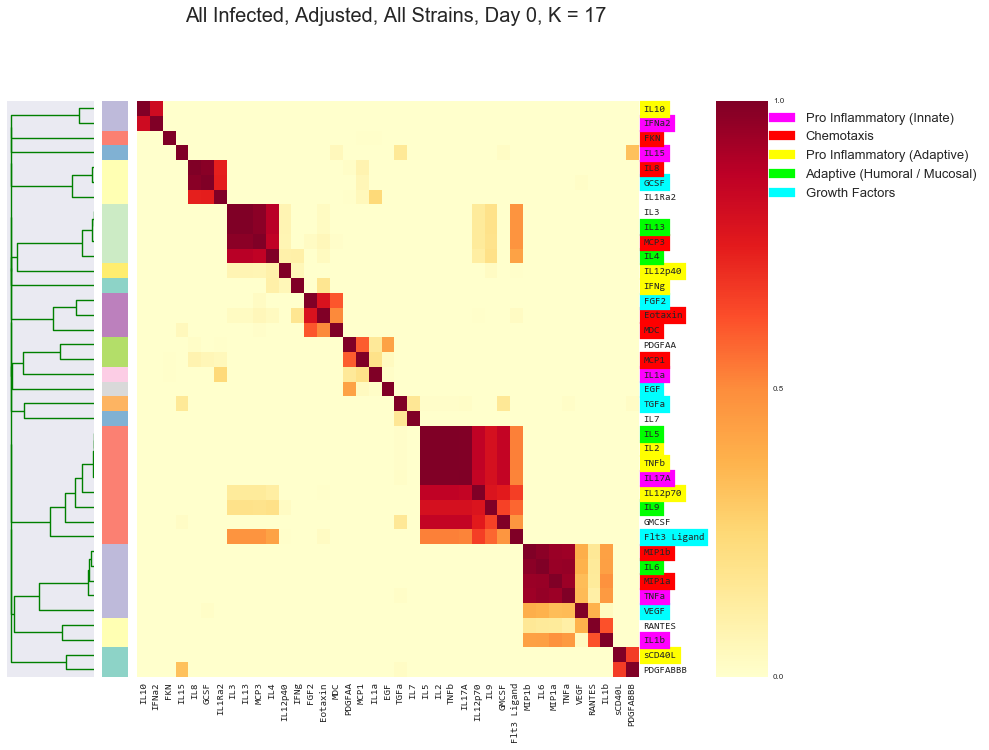

In [27]:
def computeGapStat(data, pdistFunc, clusterFunc, maxK, bootstraps=1000):
    dmat = pdistFunc(data)

    lsICD = np.zeros(maxK)
    mBSICD = np.zeros(maxK)
    stdBSICD = np.zeros(maxK)

    for K in (np.arange(maxK) + 1):
        labels = clusterFunc(dmat, K)
        lsICD[K - 1] = np.log(_intra_cluster_distances(dmat, labels))
        reps = np.zeros(bootstraps)
        for i in range(bootstraps):
            tmpDmat = pdistFunc(_bootstrap_each_column(data))
            labels = clusterFunc(tmpDmat, K)
            reps[i] = np.log(_intra_cluster_distances(tmpDmat, labels))
        mBSICD[K - 1] = reps.mean()
        stdBSICD[K - 1] = reps.std()

    gap = mBSICD - lsICD
    errBSICD = np.sqrt(1 + 1. / bootstraps) * stdBSICD

    return lsICD, mBSICD, errBSICD, gap

def _intra_cluster_distances(dmat, labels):
    """Sum of the intra-cluster distances (Wk)"""
    K = len(np.unique(labels))
    tot = 0
    for k in np.unique(labels):
        ind = labels == k
        nk = ind.sum()
        if isinstance(dmat, pd.DataFrame):
            tot += (dmat.loc[ind, :].loc[:, ind].values.flatten() ** 2).sum() / (2 * nk)
        else:
            tot += (dmat[ind, :][:, ind].flatten() ** 2).sum() / (2 * nk)
    return tot

def _bootstrap_each_column(d):
    """Returns a copy of data with row-bootstraped values
    substituted for each column independently."""
    out = d.copy()

    if isinstance(out, pd.DataFrame):
        out = out.apply(lambda col: col[np.floor(np.random.rand(len(col)) * len(col)).astype(int)], axis=0, raw=True)
    else:
        for ci in range(d.shape[1]):
            rind = np.floor(np.random.rand(d.shape[0]) * d.shape[0]).astype(int)
            out[:, ci] = out[rind, ci]

    return out




def plotGapStat(lsICD, mBSICD, errBSICD, gap, filename):
    """Descriptive plot of the Gap statistic.
    Parameters are simply the output from computeGapStat."""

    maxK = len(gap)
    plt.clf()
    plt.subplot(2, 2, 1)
    plt.plot(np.arange(maxK) + 1, np.exp(lsICD) / np.exp(lsICD[0]), 'o-', color='black', label='Observed data')
    plt.xticks(np.arange(maxK) + 1)
    plt.ylabel('Summed intra-cluster distances\nas a fraction of total\n pairwise distance', fontsize = 15)
    plt.xlabel('Number of clusters (K)', fontsize = 10)
    plt.ylim((0, 1))

    plt.subplot(2, 2, 2)
    plt.plot(np.arange(maxK) + 1, lsICD, 'o-', color='black', label='Observed data')
    plt.plot(np.arange(maxK) + 1, mBSICD, 'o-', color='red', label='Null data')
    plt.xticks(np.arange(maxK) + 1)
    plt.ylabel('$log(W_k)$', fontsize = 15)
    plt.xlabel('Number of clusters (K)', fontsize = 10)
    plt.legend(loc=0)

    plt.subplot(2, 2, 3)
    plt.plot(np.arange(maxK) + 1, gap, 'o-')
    plt.xticks(np.arange(maxK) + 1)
    plt.ylabel('Gap statistic', fontsize = 15)
    plt.xlabel('Number of clusters (K)', fontsize = 10)

    plt.subplot(2, 2, 4)
    q = gap[:-1] - (gap[1:] - errBSICD[1:])
    plt.bar(left=np.arange(maxK - 1) + 1, height=q, color='blue', align='center')
    plt.xticks(np.arange(maxK) + 1)
    plt.ylabel('$Gap(k) - (Gap(k+1) - \sigma_{k+1})$', fontsize = 15)
    plt.xlabel('Number of clusters (K)', fontsize = 10)
    # plt.tight_layout()
    path = "./{}".format(rcyc[1])
    file_name = op.join(path, filename+'.png')
    plt.savefig(file_name)
plt.figure(figsize = (20,15))






def _prepCyDf(tmp, K=3, normed=False, cluster="Cluster", percent= 0, rtol= None, atol= None, title_string = False, new_dir = False):
#     dayDf = longDf
#     tmp = tmp.pivot_table(index='ptid', columns='cytokine', values='log10_conc')
    if rtol or atol == None:
        noVar = tmp.columns[np.isclose(tmp.std(), 0)].tolist()
    else:
        noVar = tmp.columns[np.isclose(tmp.std(), 0, rtol, atol)].tolist()
    naCols = tmp.columns[(tmp.isnull().sum()) / (((tmp.isnull()).sum()) + (tmp.notnull().sum())) > (percent / 100)].tolist() 
    keepCols = [c for c in tmp.columns if not c in (noVar + naCols)]
#     dayDf = dayDf.pivot_table(index='ptid', columns='cytokine', values='log10_conc')[keepCols]
    """By setting normed=True the data our normalized based on correlation with mean analyte concentration"""
    rcyc = cy.cyclusterClass(studyStr='ADAMTS', sampleStr=cluster, normed=normed, rCyDf=tmp)
    rcyc.clusterCytokines(K=K, metric='pearson-signed', minN=0)
    rcyc.printModules()
    if title_string:
        split = title_string.split(', ')
        split_1 = split[:len(split) - 1]
        new_title_string = ""
        for item in split_1:
            new_title_string += str(item)
            new_title_string += ", "
        new_title_string = new_title_string[:-2]
        if new_dir:
            os.makedirs(new_title_string)
    return rcyc, new_title_string



def moduleCorrRatio(cyDf, labels, cyVars=None, alpha=0.05, nstraps=10000, rnd = 3):
    def ratioFunc(cyDf, intraMask, interMask):
        """smat is on the [0, 1] interval with 0 meaning perfect anti-correlation and 1 meaning perfect correlation"""
        smat = 1 - cy.corrDmatFunc(cyDf, metric='pearson-signed').values
        return np.nanmean((smat * intraMask).ravel()) / np.nanmean((smat * interMask).ravel())

    if cyVars is None:
        cyVars = cyDf.columns.tolist()

    """corrmat is on the [-1, 1] interval with 1 meaning perfect correlation and -1 meaning perfect anti-correlation"""
    corrmat = cyDf[cyVars].corr()

    intra = {}
    inter = []
    intraMask = np.nan * np.zeros(corrmat.shape)
    interMask = np.nan * np.zeros(corrmat.shape)
    for a, b in itertools.combinations(cyVars, 2):
        if not a == b:
            s = corrmat.loc[a, b]
            i, j = cyVars.index(a), cyVars.index(b)
            if labels[a] == labels[b]:
                try:
                    intra[labels[a]] = intra[labels[a]] + [s] 
                except:
                    intra[labels[a]] = [s]
                intraMask[i, j] = 1.
            else:
                inter.append(s)
                interMask[i, j] = 1.
    intra_dict = {}
    k_list = []
    i_list = list(range(1, max(rcyc[0].labels.values) + 1))
    for k, L in intra.items():
        k_list += [k]
        intra_dict[k] = round(sum(L)/float(len(L)), 4)
        for i in i_list:
            if i not in k_list:
                intra_dict[i] = None
    inter = np.percentile(inter, q=[25, 50, 75])
    for i in range(len(inter)):
        inter[i] = round(inter[i], rnd)
    
    if nstraps is None or nstraps == 0:
        return intra, inter
    
    else:
        rratios = np.zeros(nstraps)
        for strapi in range(nstraps):
            rratios[strapi] = ratioFunc(cyDf[cyVars].sample(frac=1, replace=True, axis=0), intraMask, interMask)
        ratio = np.percentile(rratios, [100*alpha/2, 50, 100*(1-alpha/2)])
    for i in range(len(ratio)):
        ratio[i] = round(ratio[i], rnd)

        return intra_dict, inter, ratio






def _colors2labels(labels, setStr = 'Set3', cmap = None):
    """Return pd.Series of colors based on labels"""
    if cmap is None:
        N = max(3, min(12, len(np.unique(labels))))
        cmap = palettable.colorbrewer.get_map(setStr, 'Qualitative', N).mpl_colors
    cmapLookup = {k:col for k, col in zip(sorted(np.unique(labels)), itertools.cycle(cmap))}
    return labels.map(cmapLookup.get)
def _clean_axis(ax):
    """Remove ticks, tick labels, and frame from axis"""
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    for sp in list(ax.spines.values()):
        sp.set_visible(False)
    ax.grid(False)
    # ax.set_axis_bgcolor('white')
def plotHierClust(dmatDf, Z, cmap_1, vRange_1, filename_1, savefile_1=False, labels_1=None, titleStr_1=None, tickSz_1= 10, cmapLabel_1=''):
    """Display a hierarchical clustering result."""
    
    vmin, vmax = vRange_1
    fig_1 = plt.gcf()
    fig_1.clf()

    if labels_1 is None:
        denAX = fig_1.add_subplot(GridSpec(1, 1, left=0.05, bottom=0.05, right=0.15, top=0.85)[0, 0])
        heatmapAX = fig_1.add_subplot(GridSpec(1, 1, left=0.16, bottom=0.05, right=0.78, top=0.85)[0, 0])
        scale_cbAX = fig_1.add_subplot(GridSpec(1, 1, left=0.87, bottom=0.05, right=0.93, top=0.85)[0, 0])
    else:
        denAX = fig_1.add_subplot(GridSpec(1, 1, left=0.05, bottom=0.05, right=0.15, top=0.85)[0, 0])
        cbAX = fig_1.add_subplot(GridSpec(1, 1, left=0.16, bottom=0.05, right=0.19, top=0.85)[0, 0])
        heatmapAX = fig_1.add_subplot(GridSpec(1, 1, left=0.2, bottom=0.05, right=0.78, top=0.85)[0, 0])
        scale_cbAX = fig_1.add_subplot(GridSpec(1, 1, left=0.87, bottom=0.05, right=0.93, top=0.85)[0, 0])

    my_norm = mpl.colors.Normalize(vmin = vmin, vmax = vmax)

    """Dendrogaram along the rows"""
    plt.sca(denAX)
    denD = sch.dendrogram(Z, p = 2, truncate_mode = 'none', color_threshold=np.inf, orientation='left')
    colInd = denD['leaves']
    _clean_axis(denAX)

    if not labels_1 is None:
        cbSE = _colors2labels(labels_1)
        axi = cbAX.imshow([[x] for x in cbSE.iloc[colInd].values], interpolation='nearest', aspect='auto', origin='lower')
        
        _clean_axis(cbAX)

    """Heatmap plot"""
    axi = heatmapAX.imshow(dmatDf.values[colInd,:][:, colInd], interpolation='nearest', aspect='auto', origin='lower', norm=my_norm, cmap=cmap_1)
    _clean_axis(heatmapAX)

    """Column tick labels along the rows"""
    if tickSz_1 is None:
        heatmapAX.set_yticks(())
        heatmapAX.set_xticks(())
    else:
        heatmapAX.set_yticks(np.arange(dmatDf.shape[1]))
        heatmapAX.yaxis.set_ticks_position('right')
        heatmapAX.set_yticklabels(dmatDf.columns[colInd], fontsize=tickSz_1, fontname='Consolas')

        """Column tick labels"""
        heatmapAX.set_xticks(np.arange(dmatDf.shape[1]))
        heatmapAX.xaxis.set_ticks_position('top')
        xlabelsL = heatmapAX.set_xticklabels(dmatDf.columns[colInd], fontsize=tickSz_1, rotation=90, fontname='Consolas')

    
    """Assign cytokines to groups and change their color on the y-axis"""
    pro_inflammatory_innate = ['IFNa2', 'IL15', 'IL17a', 'IL18', 'IL1a', 'IL1b', 'IP10', 'TNFa', 'IL-IRa']
    chemotaxis = ['Eotaxin', 'FKN', 'GRO', 'IL8', 'MCP1', 'MCP3', 'MDC', 'MIP1a', 'MIP1b']
    pro_inflammatory_adaptive = ['IFNg', 'IL2', 'IL10', 'IL12p40', 'IL12p70', 'sCD40L', 'TNFb']
    adaptive = ['IL4', 'IL5', 'IL6', 'IL9', 'IL13']
    growth_factors = ['EGF', 'FGF2', 'Flt3 Ligand', 'GCSF', 'TGFa', 'VEGF']
        
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in pro_inflammatory_innate:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('blue')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in chemotaxis:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('red')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in pro_inflammatory_adaptive:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('yellow')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in adaptive:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('green')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in growth_factors:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('purple')

    """Add Legend for Cytokine Groups"""
    pro_inflammatory_innate_legend = mpatches.Patch(color = 'blue', label = 'Pro Inflammatory (Innate)')
    chemotaxis_legend = mpatches.Patch(color = 'red', label = 'Chemotaxis')
    pro_inflammatory_adaptive_legend = mpatches.Patch(color = 'yellow', label = 'Pro Inflammatory (Adaptive)')
    adaptive_legend = mpatches.Patch(color = 'green', label = 'Adaptive (Humoral / Mucosal)')
    growth_factors_legend = mpatches.Patch(color = 'purple', label = 'Growth Factors')
    heatmapAX.legend(handles = [pro_inflammatory_innate_legend, chemotaxis_legend, pro_inflammatory_adaptive_legend, adaptive_legend, growth_factors_legend], bbox_to_anchor = (1.7, 1), fontsize = 13)
                
    
    """Add a colorbar"""
    cb = fig_1.colorbar(axi, scale_cbAX) # note that we could pass the norm explicitly with norm=my_norm
    cb.set_label(cmapLabel_1)
    cb.set_ticks([-1, -0.5, 0, 0.5, 1])
    """Make colorbar labels smaller"""
    for t in cb.ax.yaxis.get_ticklabels():
        t.set_fontsize('small')
    heatmapAX.xaxis.tick_bottom()
    heatmapAX.invert_xaxis()
    
    """Give Graph Title"""
    if titleStr_1:
        plt.suptitle(titleStr_1, fontsize = 20)
    
    """Save Graph to Specified Path"""
    path = "./{}/{}".format(rcyc[1], title_string)
    file_name = op.join(path, filename_1+'.png')
    fig_1.savefig(file_name, bbox_inches = 'tight', dpi = 300)

                
plt.figure(figsize = (12,10))




def plotHierClust_1(dmatDf, Z, cmap_2, vRange_2, filename_2, savefile_2=False, labels_2=None, titleStr_2=None, tickSz_2= 10, cmapLabel_2=''):
    """Display a hierarchical clustering result."""
    
    vmin, vmax = vRange_2
    fig_2 = plt.gcf()
    fig_2.clf()

    if labels_2 is None:
        denAX = fig_2.add_subplot(GridSpec(1, 1, left=0.05, bottom=0.05, right=0.15, top=0.85)[0, 0])
        heatmapAX = fig_2.add_subplot(GridSpec(1, 1, left=0.16, bottom=0.05, right=0.78, top=0.85)[0, 0])
        scale_cbAX = fig_2.add_subplot(GridSpec(1, 1, left=0.87, bottom=0.05, right=0.93, top=0.85)[0, 0])
    else:
        denAX = fig_2.add_subplot(GridSpec(1, 1, left=0.05, bottom=0.05, right=0.15, top=0.85)[0, 0])
        cbAX = fig_2.add_subplot(GridSpec(1, 1, left=0.16, bottom=0.05, right=0.19, top=0.85)[0, 0])
        heatmapAX = fig_2.add_subplot(GridSpec(1, 1, left=0.2, bottom=0.05, right=0.78, top=0.85)[0, 0])
        scale_cbAX = fig_2.add_subplot(GridSpec(1, 1, left=0.87, bottom=0.05, right=0.93, top=0.85)[0, 0])

    my_norm = mpl.colors.Normalize(vmin = vmin, vmax = vmax)

    """Dendrogaram along the rows"""
    plt.sca(denAX)
    denD = sch.dendrogram(Z, p = 2, truncate_mode = 'none', color_threshold=np.inf, orientation='left')
    colInd = denD['leaves']
    _clean_axis(denAX)

    if not labels_2 is None:
        cbSE = _colors2labels(labels_2)
        axi = cbAX.imshow([[x] for x in cbSE.iloc[colInd].values], interpolation='nearest', aspect='auto', origin='lower')
        
        _clean_axis(cbAX)

    """Heatmap plot"""
    axi = heatmapAX.imshow(dmatDf.values[colInd,:][:, colInd], interpolation='nearest', aspect='auto', origin='lower', norm=my_norm, cmap=cmap_2)
    _clean_axis(heatmapAX)

    """Column tick labels along the rows"""
    if tickSz_2 is None:
        heatmapAX.set_yticks(())
        heatmapAX.set_xticks(())
    else:
        heatmapAX.set_yticks(np.arange(dmatDf.shape[1]))
        heatmapAX.yaxis.set_ticks_position('right')
        heatmapAX.set_yticklabels(dmatDf.columns[colInd], fontsize=tickSz_2, fontname='Consolas')

        """Column tick labels"""
        heatmapAX.set_xticks(np.arange(dmatDf.shape[1]))
        xlabelsL = heatmapAX.set_xticklabels(dmatDf.columns[colInd], fontsize=tickSz_2, rotation=90, fontname='Consolas')
        
    """Assign cytokines to groups and change their color on the y-axis"""
    pro_inflammatory_innate = ['IFNa2', 'IL15', 'IL17A', 'IL18', 'IL1a', 'IL1b', 'IP10', 'TNFa', 'IL-IRa']
    chemotaxis = ['Eotaxin', 'FKN', 'GRO', 'IL8', 'MCP1', 'MCP3', 'MDC', 'MIP1a', 'MIP1b']
    pro_inflammatory_adaptive = ['IFNg', 'IL2', 'IL10', 'IL12p40', 'IL12p70', 'sCD40L', 'TNFb']
    adaptive = ['IL4', 'IL5', 'IL6', 'IL9', 'IL13']
    growth_factors = ['EGF', 'FGF2', 'Flt3 Ligand', 'GCSF', 'TGFa', 'VEGF']

    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in pro_inflammatory_innate:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('magenta')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in chemotaxis:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('red')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in pro_inflammatory_adaptive:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('yellow')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in adaptive:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('lime')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in growth_factors:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('cyan')

    """Add Legend for Cytokine Groups"""
    pro_inflammatory_innate_legend = mpatches.Patch(color = 'magenta', label = 'Pro Inflammatory (Innate)')
    chemotaxis_legend = mpatches.Patch(color = 'red', label = 'Chemotaxis')
    pro_inflammatory_adaptive_legend = mpatches.Patch(color = 'yellow', label = 'Pro Inflammatory (Adaptive)')
    adaptive_legend = mpatches.Patch(color = 'lime', label = 'Adaptive (Humoral / Mucosal)')
    growth_factors_legend = mpatches.Patch(color = 'cyan', label = 'Growth Factors')
    heatmapAX.legend(handles = [pro_inflammatory_innate_legend, chemotaxis_legend, pro_inflammatory_adaptive_legend, adaptive_legend, growth_factors_legend], bbox_to_anchor = (1.7, 1), fontsize = 13)
    
    """Add a colorbar"""
    cb = fig_2.colorbar(axi, scale_cbAX) # note that we could pass the norm explicitly with norm=my_norm
    cb.set_label(cmapLabel_2)
    cb.set_ticks([-1, -0.5, 0, 0.5, 1])

    """Make colorbar labels smaller"""
    for t in cb.ax.yaxis.get_ticklabels():
        t.set_fontsize('small')
    heatmapAX.xaxis.tick_bottom()
    heatmapAX.invert_xaxis()
    

    """Give Graph Title"""
    if titleStr_2:
        plt.suptitle(titleStr_2, fontsize = 20)
    
    """Save Graph to Specified Path"""
    path = "./{}/{}".format(rcyc[1], title_string)
    file_name = op.join(path, filename_2+'.png')
    fig_2.savefig(file_name, bbox_inches = 'tight', dpi = 300)
                
                
"""Create and Save Data Table of Clusters and Cytokines"""
def makeDataTable(savefile):
    if savefile:
        dict_1 = {}
        for i in range(len(rcyc[0].labels.index)):
            dict_1[rcyc[0].labels.index[i]] = rcyc[0].labels.values[i]

        sorted_by_value = sorted(dict_1.items(), key=lambda kv: kv[1])

        table = {}
        for tup in sorted_by_value:
            if tup[1] in table.keys():
                table[tup[1]] += (tup[0],)
            else:
                table[tup[1]] = (tup[0],)

        sorted_by_value_1 = sorted(table.items(), key=lambda kv: kv[1])

        new_table = []
        i = 1
        while i < len(sorted_by_value_1) + 1:
            for tup in sorted_by_value_1:
                if int(tup[0]) == i:
                    new_table += [tup]
                    i += 1
                else:
                    continue

        for i in range(1, len(new_table) + 1):
            avr_exp = '%s' % float('%.4g' % mod["All{}".format(i)].mean())
            for item in new_table:
                if new_table.index(item) + 1 == i:
                    new_item_1 = list(item)
                    new_item_1.append(avr_exp)
                    new_table[new_table.index(item)] = tuple(new_item_1)
                    break


        header = [('Cluster', 'Cytokines', 'Average Expression', 'Intra-Corr', 'Inter-Corr (IQR)', 'Corr-Ratio')]
        header += new_table

        for k, v in corr[0].items():
            for item in header:
                if header.index(item) == k:
                    if v:
                        new_item = list(item)
                        new_item.append(v)
                        new_item.append(corr[1])
                        new_item.append(corr[2])
                        header[header.index(item)] = tuple(new_item)
                    else:
                        new_item = list(item)
                        new_item.append("--")
                        new_item.append(corr[1])
                        new_item.append(corr[2])
                        header[header.index(item)] = tuple(new_item)
                    break


        t = Texttable()
        t.add_rows(header)

        text_file = open(op.join("./{}/{}".format(rcyc[1], title_string),"Data Table -- {}.txt".format(title_string)), "w")
        text_file.write(t.draw())
        text_file.close()

        new_dict = {}
        for i in new_table:
            new_dict[i[0]] = i[1]

        list_1 = []
        for cytokine in rcyc[0].labels.index:
            list_1 += [cytokine]
        text_file_1 = open(op.join("./{}/{}/".format(rcyc[1], title_string),"Cluster Data -- {}.txt".format(title_string)), "w")
        text_file_1.write(str(list_1))
        text_file_1.write('\n')
        text_file_1.write(str(rcyc[0].labels.values))
        text_file_1.close()
        
        
        
def makeModuleVariables(cyDf, labels, sampleStr='All', dropped=None):
    if dropped is None:
        dropped = pd.Series(np.zeros((labels.shape[0]), dtype = bool), index = labels.index)
    out = None
    uLabels = np.unique(labels)
    for lab in uLabels:
        members = labels.index[(labels == lab) & (~dropped)]
        tmpS = cyDf.loc[:, members].mean(axis = 1, skipna=True)
        tmpS.name = '%s%s' % (sampleStr, lab)
        if out is None:
            out = pd.DataFrame(tmpS)
        else:
            out = out.join(tmpS)
    out.to_csv(op.join("./{}/{}".format(rcyc[1], title_string),"Module Data -- {}.csv".format(title_string)))
    return out
    
    
    
def makeModuleVariables_1(cyDf, labels, sampleStr='All', dropped=None):
    if dropped is None:
        dropped = pd.Series(np.zeros((labels.shape[0]), dtype = bool), index = labels.index)
    standardizeFunc = lambda col: (col - np.nanmean(col))/np.nanstd(col)
    out = None
    uLabels = np.unique(labels)
    for lab in uLabels:
        members = labels.index[(labels == lab) & (~dropped)]
        tmpS = cyDf.loc[:, members].apply(standardizeFunc, raw = True).mean(axis = 1, skipna=True)
        tmpS.name = '%s%s' % (sampleStr, lab)
        if out is None:
            out = pd.DataFrame(tmpS)
        else:
            out = out.join(tmpS)
    out = out.apply(standardizeFunc)
    out.to_csv(op.join("./{}/{}".format(rcyc[1], title_string),"Normalized Module Data -- {}.csv".format(title_string)))
    
plt.figure(figsize = (12,10))

def mainPlot(savefile, dmatDf, Z, dmatDf_1, Z_1, title_string, cmap_1 = None, vRange_1 = 0, filename_1 = None, savefile_1 = False, labels_1 = None, titleStr_1 = None, cmap_2 = None, vRange_2 = 0, filename_2 = None, savefile_2 = False, labels_2 = None, titleStr_2 = None):
    os.mkdir(op.join("./{}/{}".format(rcyc[1], title_string)))
    
    plotHierClust(dmatDf, Z, cmap_1, vRange_1, filename_1, savefile_1, labels_1, titleStr_1)
    plotHierClust_1(dmatDf_1, Z_1, cmap_2, vRange_2, filename_2, savefile_2, labels_2, titleStr_2)


i = 6
first = True
while i < 18:
    title_string = "All Infected, Adjusted, All Strains, Day 0, K = {}".format(i)
    if first:
        rcyc = _prepCyDf(df_prep, K=i, normed=False, cluster="All", percent= 10, title_string = title_string, new_dir = True)
        Gap_1 = computeGapStat(df_prep, cy.corrDmatFunc, cy.hierClusterFunc, 30, bootstraps=100)
        plotGapStat(Gap_1[0], Gap_1[1], Gap_1[2], Gap_1[3],
            filename = 'Gap Stat -- {}'.format(rcyc[1]))
        print(Gap_1[3])
        first = False
    else:
        rcyc = _prepCyDf(df_prep, K=i, normed=False, cluster="All", percent= 10, title_string = title_string)
    save_file = True
    corr = moduleCorrRatio(rcyc[0].cyDf, rcyc[0].labels, cyVars=None, alpha=0.05, nstraps=10000)
    mainPlot(save_file,
         rcyc[0].cyDf.corr(method="pearson", min_periods=1), 
         rcyc[0].Z, 
         1 - rcyc[0].pwrel,
         cy.hierClusterFunc(rcyc[0].pwrel, returnLinkageMat=True, method = "complete")[1],
         title_string,
         filename_1 = 'Correlation, {}'.format(title_string),
         cmap_1 = palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap, 
         vRange_1 = (-1, 1), 
         labels_1 = rcyc[0].labels, 
         titleStr_1 = "Correlation, {}".format(title_string),
         savefile_1 = save_file,
         labels_2 = rcyc[0].labels,
         titleStr_2 = '{}'.format(title_string),
         vRange_2 = (0, 1),
         cmap_2 = cm.YlOrRd,
         filename_2 = '{}'.format(title_string))
    mod = makeModuleVariables(rcyc[0].cyDf, rcyc[0].labels)
    makeDataTable(True)
    makeModuleVariables_1(rcyc[0].cyDf, rcyc[0].labels)
    i += 1



        

In [224]:

"""A wide df has one sample per row (analyte measurements across the columns)"""



def _prepCyDf(tmp, K=3, normed=False, cluster="Cluster", percent= 0, rtol= None, atol= None):
#     dayDf = longDf
#     tmp = tmp.pivot_table(index='ptid', columns='cytokine', values='log10_conc')
    if rtol or atol == None:
        noVar = tmp.columns[np.isclose(tmp.std(), 0)].tolist()
    else:
        noVar = tmp.columns[np.isclose(tmp.std(), 0, rtol, atol)].tolist()
    naCols = tmp.columns[(tmp.isnull().sum()) / (((tmp.isnull()).sum()) + (tmp.notnull().sum())) > (percent / 100)].tolist() 
    keepCols = [c for c in tmp.columns if not c in (noVar + naCols)]
#     dayDf = dayDf.pivot_table(index='ptid', columns='cytokine', values='log10_conc')[keepCols]
    """By setting normed=True the data our normalized based on correlation with mean analyte concentration"""
    rcyc = cy.cyclusterClass(studyStr='ADAMTS', sampleStr=cluster, normed=normed, rCyDf=tmp)
    rcyc.clusterCytokines(K=K, metric='pearson-signed', minN=0)
    rcyc.printModules()
    return rcyc
        

rcyc = _prepCyDf(df_prep, K=12, normed=False, cluster="All", percent= 10)

title_string = "Strain B, Adjusted, Day 0, K = 12"
save_file = True

All1
IL12p40
IL7
PDGFABBB
sCD40L

All2
IL1b
MIP1a
MIP1b
RANTES
TNFa
VEGF

All3
GCSF
IL6
IL8

All4
IL1Ra2

All5
Flt3 Ligand
GMCSF
IL4

All6
IL12p70
IL13
IL17A
IL2
IL3
IL5
IL9
TNFb

All7
TGFa

All8
Eotaxin
FGF2
IFNg
IL15
MCP3
MDC

All9
EGF
IL1a
PDGFAA

All10
FKN
MCP1

All11
IFNa2

All12
IL10



<Figure size 864x720 with 0 Axes>

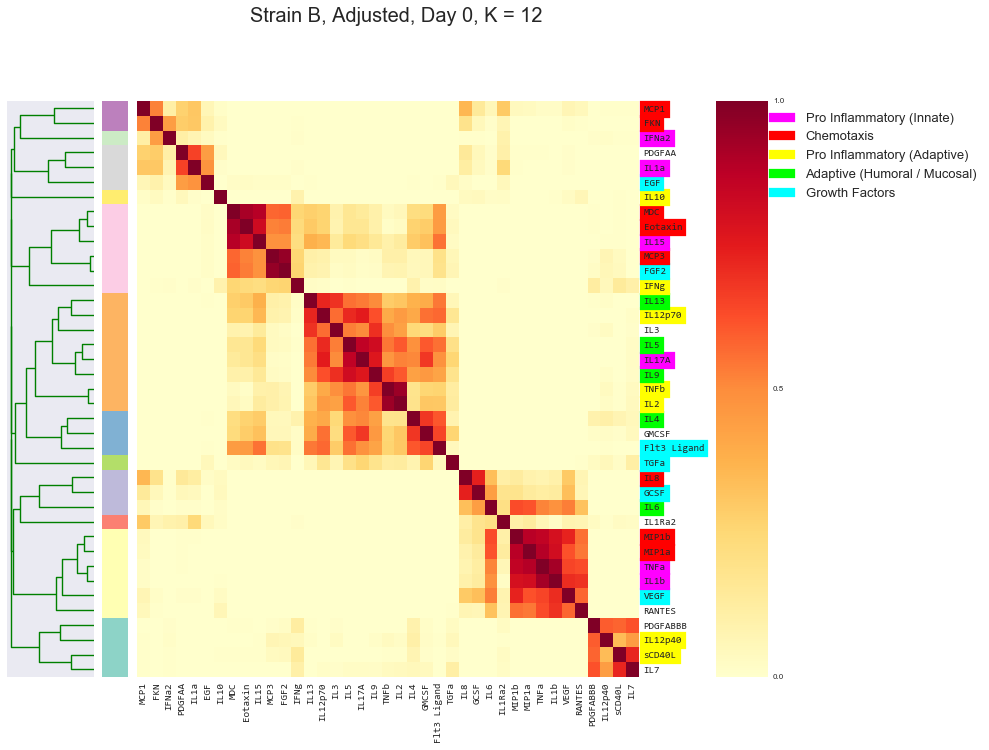

In [227]:
def _colors2labels(labels, setStr = 'Set3', cmap = None):
    """Return pd.Series of colors based on labels"""
    if cmap is None:
        N = max(3, min(12, len(np.unique(labels))))
        cmap = palettable.colorbrewer.get_map(setStr, 'Qualitative', N).mpl_colors
    cmapLookup = {k:col for k, col in zip(sorted(np.unique(labels)), itertools.cycle(cmap))}
    return labels.map(cmapLookup.get)
def _clean_axis(ax):
    """Remove ticks, tick labels, and frame from axis"""
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    for sp in list(ax.spines.values()):
        sp.set_visible(False)
    ax.grid(False)
    # ax.set_axis_bgcolor('white')
def plotHierClust(dmatDf, Z, cmap_1, vRange_1, filename_1, savefile_1=False, labels_1=None, titleStr_1=None, tickSz_1= 10, cmapLabel_1=''):
    """Display a hierarchical clustering result."""
    
    vmin, vmax = vRange_1
    fig_1 = plt.gcf()
    fig_1.clf()

    if labels_1 is None:
        denAX = fig_1.add_subplot(GridSpec(1, 1, left=0.05, bottom=0.05, right=0.15, top=0.85)[0, 0])
        heatmapAX = fig_1.add_subplot(GridSpec(1, 1, left=0.16, bottom=0.05, right=0.78, top=0.85)[0, 0])
        scale_cbAX = fig_1.add_subplot(GridSpec(1, 1, left=0.87, bottom=0.05, right=0.93, top=0.85)[0, 0])
    else:
        denAX = fig_1.add_subplot(GridSpec(1, 1, left=0.05, bottom=0.05, right=0.15, top=0.85)[0, 0])
        cbAX = fig_1.add_subplot(GridSpec(1, 1, left=0.16, bottom=0.05, right=0.19, top=0.85)[0, 0])
        heatmapAX = fig_1.add_subplot(GridSpec(1, 1, left=0.2, bottom=0.05, right=0.78, top=0.85)[0, 0])
        scale_cbAX = fig_1.add_subplot(GridSpec(1, 1, left=0.87, bottom=0.05, right=0.93, top=0.85)[0, 0])

    my_norm = mpl.colors.Normalize(vmin = vmin, vmax = vmax)

    """Dendrogaram along the rows"""
    plt.sca(denAX)
    denD = sch.dendrogram(Z, p = 2, truncate_mode = 'none', color_threshold=np.inf, orientation='left')
    colInd = denD['leaves']
    _clean_axis(denAX)

    if not labels_1 is None:
        cbSE = _colors2labels(labels_1)
        axi = cbAX.imshow([[x] for x in cbSE.iloc[colInd].values], interpolation='nearest', aspect='auto', origin='lower')
        
        _clean_axis(cbAX)

    """Heatmap plot"""
    axi = heatmapAX.imshow(dmatDf.values[colInd,:][:, colInd], interpolation='nearest', aspect='auto', origin='lower', norm=my_norm, cmap=cmap_1)
    _clean_axis(heatmapAX)

    """Column tick labels along the rows"""
    if tickSz_1 is None:
        heatmapAX.set_yticks(())
        heatmapAX.set_xticks(())
    else:
        heatmapAX.set_yticks(np.arange(dmatDf.shape[1]))
        heatmapAX.yaxis.set_ticks_position('right')
        heatmapAX.set_yticklabels(dmatDf.columns[colInd], fontsize=tickSz_1, fontname='Consolas')

        """Column tick labels"""
        heatmapAX.set_xticks(np.arange(dmatDf.shape[1]))
        heatmapAX.xaxis.set_ticks_position('top')
        xlabelsL = heatmapAX.set_xticklabels(dmatDf.columns[colInd], fontsize=tickSz_1, rotation=90, fontname='Consolas')

    
    """Assign cytokines to groups and change their color on the y-axis"""
    pro_inflammatory_innate = ['IFNa2', 'IL15', 'IL17a', 'IL18', 'IL1a', 'IL1b', 'IP10', 'TNFa', 'IL-IRa']
    chemotaxis = ['Eotaxin', 'FKN', 'GRO', 'IL8', 'MCP1', 'MCP3', 'MDC', 'MIP1a', 'MIP1b']
    pro_inflammatory_adaptive = ['IFNg', 'IL2', 'IL10', 'IL12p40', 'IL12p70', 'sCD40L', 'TNFb']
    adaptive = ['IL4', 'IL5', 'IL6', 'IL9', 'IL13']
    growth_factors = ['EGF', 'FGF2', 'Flt3 Ligand', 'GCSF', 'TGFa', 'VEGF']
        
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in pro_inflammatory_innate:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('blue')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in chemotaxis:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('red')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in pro_inflammatory_adaptive:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('yellow')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in adaptive:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('green')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in growth_factors:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('purple')

    """Add Legend for Cytokine Groups"""
    pro_inflammatory_innate_legend = mpatches.Patch(color = 'blue', label = 'Pro Inflammatory (Innate)')
    chemotaxis_legend = mpatches.Patch(color = 'red', label = 'Chemotaxis')
    pro_inflammatory_adaptive_legend = mpatches.Patch(color = 'yellow', label = 'Pro Inflammatory (Adaptive)')
    adaptive_legend = mpatches.Patch(color = 'green', label = 'Adaptive (Humoral / Mucosal)')
    growth_factors_legend = mpatches.Patch(color = 'purple', label = 'Growth Factors')
    heatmapAX.legend(handles = [pro_inflammatory_innate_legend, chemotaxis_legend, pro_inflammatory_adaptive_legend, adaptive_legend, growth_factors_legend], bbox_to_anchor = (1.7, 1), fontsize = 13)
                
    
    """Add a colorbar"""
    cb = fig_1.colorbar(axi, scale_cbAX) # note that we could pass the norm explicitly with norm=my_norm
    cb.set_label(cmapLabel_1)
    cb.set_ticks([-1, -0.5, 0, 0.5, 1])
    """Make colorbar labels smaller"""
    for t in cb.ax.yaxis.get_ticklabels():
        t.set_fontsize('small')
    heatmapAX.xaxis.tick_bottom()
    heatmapAX.invert_xaxis()
    
    """Give Graph Title"""
    if titleStr_1:
        plt.suptitle(titleStr_1, fontsize = 20)
    
    """Save Graph to Specified Path"""
    path = "./{}/".format(title_string)
    file_name = op.join(path, filename_1+'.png')
    fig_1.savefig(file_name, bbox_inches = 'tight', dpi = 300)

                
plt.figure(figsize = (12,10))




def plotHierClust_1(dmatDf, Z, cmap_2, vRange_2, filename_2, savefile_2=False, labels_2=None, titleStr_2=None, tickSz_2= 10, cmapLabel_2=''):
    """Display a hierarchical clustering result."""
    
    vmin, vmax = vRange_2
    fig_2 = plt.gcf()
    fig_2.clf()

    if labels_2 is None:
        denAX = fig_2.add_subplot(GridSpec(1, 1, left=0.05, bottom=0.05, right=0.15, top=0.85)[0, 0])
        heatmapAX = fig_2.add_subplot(GridSpec(1, 1, left=0.16, bottom=0.05, right=0.78, top=0.85)[0, 0])
        scale_cbAX = fig_2.add_subplot(GridSpec(1, 1, left=0.87, bottom=0.05, right=0.93, top=0.85)[0, 0])
    else:
        denAX = fig_2.add_subplot(GridSpec(1, 1, left=0.05, bottom=0.05, right=0.15, top=0.85)[0, 0])
        cbAX = fig_2.add_subplot(GridSpec(1, 1, left=0.16, bottom=0.05, right=0.19, top=0.85)[0, 0])
        heatmapAX = fig_2.add_subplot(GridSpec(1, 1, left=0.2, bottom=0.05, right=0.78, top=0.85)[0, 0])
        scale_cbAX = fig_2.add_subplot(GridSpec(1, 1, left=0.87, bottom=0.05, right=0.93, top=0.85)[0, 0])

    my_norm = mpl.colors.Normalize(vmin = vmin, vmax = vmax)

    """Dendrogaram along the rows"""
    plt.sca(denAX)
    denD = sch.dendrogram(Z, p = 2, truncate_mode = 'none', color_threshold=np.inf, orientation='left')
    colInd = denD['leaves']
    _clean_axis(denAX)

    if not labels_2 is None:
        cbSE = _colors2labels(labels_2)
        axi = cbAX.imshow([[x] for x in cbSE.iloc[colInd].values], interpolation='nearest', aspect='auto', origin='lower')
        
        _clean_axis(cbAX)

    """Heatmap plot"""
    axi = heatmapAX.imshow(dmatDf.values[colInd,:][:, colInd], interpolation='nearest', aspect='auto', origin='lower', norm=my_norm, cmap=cmap_2)
    _clean_axis(heatmapAX)

    """Column tick labels along the rows"""
    if tickSz_2 is None:
        heatmapAX.set_yticks(())
        heatmapAX.set_xticks(())
    else:
        heatmapAX.set_yticks(np.arange(dmatDf.shape[1]))
        heatmapAX.yaxis.set_ticks_position('right')
        heatmapAX.set_yticklabels(dmatDf.columns[colInd], fontsize=tickSz_2, fontname='Consolas')

        """Column tick labels"""
        heatmapAX.set_xticks(np.arange(dmatDf.shape[1]))
        xlabelsL = heatmapAX.set_xticklabels(dmatDf.columns[colInd], fontsize=tickSz_2, rotation=90, fontname='Consolas')
        
    """Assign cytokines to groups and change their color on the y-axis"""
    pro_inflammatory_innate = ['IFNa2', 'IL15', 'IL17A', 'IL18', 'IL1a', 'IL1b', 'IP10', 'TNFa', 'IL-IRa']
    chemotaxis = ['Eotaxin', 'FKN', 'GRO', 'IL8', 'MCP1', 'MCP3', 'MDC', 'MIP1a', 'MIP1b']
    pro_inflammatory_adaptive = ['IFNg', 'IL2', 'IL10', 'IL12p40', 'IL12p70', 'sCD40L', 'TNFb']
    adaptive = ['IL4', 'IL5', 'IL6', 'IL9', 'IL13']
    growth_factors = ['EGF', 'FGF2', 'Flt3 Ligand', 'GCSF', 'TGFa', 'VEGF']

    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in pro_inflammatory_innate:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('magenta')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in chemotaxis:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('red')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in pro_inflammatory_adaptive:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('yellow')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in adaptive:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('lime')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in growth_factors:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('cyan')

    """Add Legend for Cytokine Groups"""
    pro_inflammatory_innate_legend = mpatches.Patch(color = 'magenta', label = 'Pro Inflammatory (Innate)')
    chemotaxis_legend = mpatches.Patch(color = 'red', label = 'Chemotaxis')
    pro_inflammatory_adaptive_legend = mpatches.Patch(color = 'yellow', label = 'Pro Inflammatory (Adaptive)')
    adaptive_legend = mpatches.Patch(color = 'lime', label = 'Adaptive (Humoral / Mucosal)')
    growth_factors_legend = mpatches.Patch(color = 'cyan', label = 'Growth Factors')
    heatmapAX.legend(handles = [pro_inflammatory_innate_legend, chemotaxis_legend, pro_inflammatory_adaptive_legend, adaptive_legend, growth_factors_legend], bbox_to_anchor = (1.7, 1), fontsize = 13)
    
    """Add a colorbar"""
    cb = fig_2.colorbar(axi, scale_cbAX) # note that we could pass the norm explicitly with norm=my_norm
    cb.set_label(cmapLabel_2)
    cb.set_ticks([-1, -0.5, 0, 0.5, 1])

    """Make colorbar labels smaller"""
    for t in cb.ax.yaxis.get_ticklabels():
        t.set_fontsize('small')
    heatmapAX.xaxis.tick_bottom()
    heatmapAX.invert_xaxis()
    

    """Give Graph Title"""
    if titleStr_2:
        plt.suptitle(titleStr_2, fontsize = 20)
    
    """Save Graph to Specified Path"""
    path = "./{}/".format(title_string)
    file_name = op.join(path, filename_2+'.png')
    fig_2.savefig(file_name, bbox_inches = 'tight', dpi = 300)
                
                
    """Create and Save Data Table of Clusters and Cytokines"""
    if savefile_2:
        dict_1 = {}
        for i in range(len(rcyc.labels.index)):
            dict_1[rcyc.labels.index[i]] = rcyc.labels.values[i]

        sorted_by_value = sorted(dict_1.items(), key=lambda kv: kv[1])

        table = {}
        for tup in sorted_by_value:
            if tup[1] in table.keys():
                table[tup[1]] += (tup[0],)
            else:
                table[tup[1]] = (tup[0],)

        sorted_by_value_1 = sorted(table.items(), key=lambda kv: kv[1])

        new_table = []
        i = 1
        while i < len(sorted_by_value_1):
            for tup in sorted_by_value_1:
                if int(tup[0]) == i:
                    new_table += [tup]
                    i += 1
                else:
                    continue

        header = [('Cluster', 'Cytokines')]
        header += new_table

        t = Texttable()
        t.add_rows(header)

        text_file = open(op.join("./{}/".format(title_string),"Data Table -- {}.txt".format(title_string)), "w")
        text_file.write(t.draw())
        text_file.close()
        
        new_dict = {}
        for i in new_table:
            new_dict[i[0]] = i[1]

        text_file_1 = open(op.join("./{}/".format(title_string),"Cluster Dict -- {}.txt".format(title_string)), "w")
        text_file_1.write(str(new_dict))
        text_file_1.close()
        
        


plt.figure(figsize = (12,10))

def mainPlot(savefile, dmatDf, Z, dmatDf_1, Z_1, cmap_1 = None, vRange_1 = 0, filename_1 = None, savefile_1 = False, labels_1 = None, titleStr_1 = None, cmap_2 = None, vRange_2 = 0, filename_2 = None, savefile_2 = False, labels_2 = None, titleStr_2 = None):
    os.makedirs(title_string)
    
    plotHierClust(dmatDf, Z, cmap_1, vRange_1, filename_1, savefile_1, labels_1, titleStr_1)
    plotHierClust_1(dmatDf_1, Z_1, cmap_2, vRange_2, filename_2, savefile_2, labels_2, titleStr_2)


mainPlot(save_file,
         rcyc.cyDf.corr(method="pearson", min_periods=1), 
         rcyc.Z, 
         1 - rcyc.pwrel,
         cy.hierClusterFunc(rcyc.pwrel, returnLinkageMat=True, method = "complete")[1],
         filename_1 = 'Correlation, {}'.format(title_string),
         cmap_1 = palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap, 
         vRange_1 = (-1, 1), 
         labels_1 = rcyc.labels, 
         titleStr_1 = "Correlation, {}".format(title_string),
         savefile_1 = save_file,
         labels_2 = rcyc.labels,
         titleStr_2 = '{}'.format(title_string),
         vRange_2 = (0, 1),
         cmap_2 = cm.YlOrRd,
         filename_2 = '{}'.format(title_string),
         savefile_2 = save_file)



        


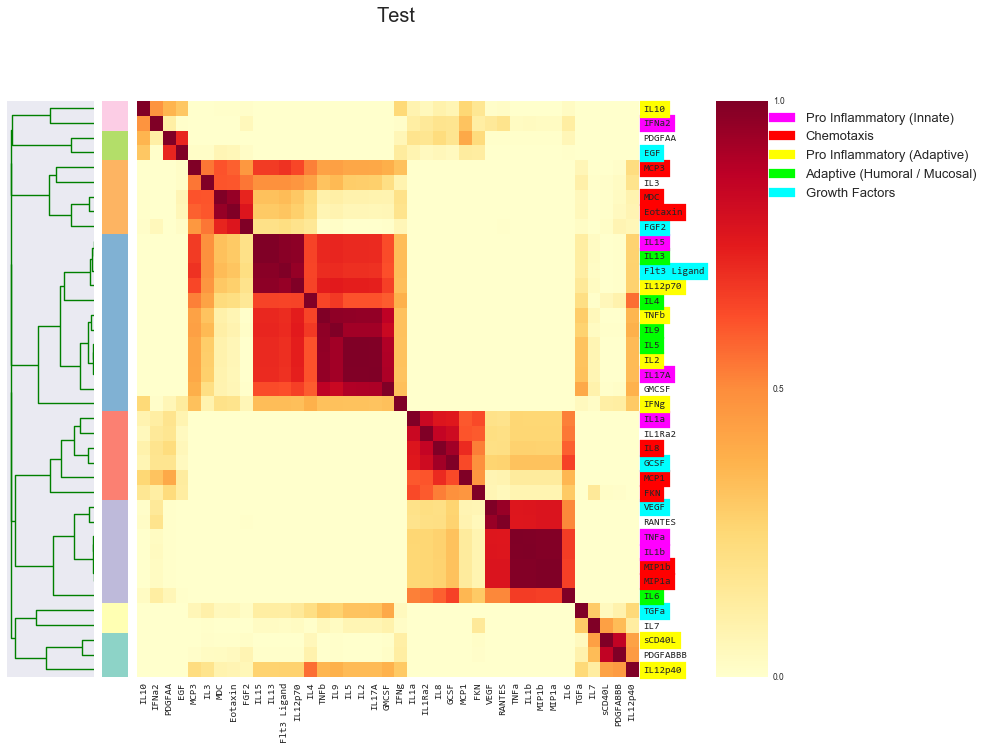

In [116]:
def plotHierClust_1(dmatDf, Z, cmap_2, vRange_2, filename_2, savefile_2=False, labels_2=None, titleStr_2=None, tickSz_2= 10, cmapLabel_2=''):
    """Display a hierarchical clustering result."""
    
    vmin, vmax = vRange_2
    fig = plt.gcf()
    fig.clf()

    if labels_2 is None:
        denAX = fig.add_subplot(GridSpec(1, 1, left=0.05, bottom=0.05, right=0.15, top=0.85)[0, 0])
        heatmapAX = fig.add_subplot(GridSpec(1, 1, left=0.16, bottom=0.05, right=0.78, top=0.85)[0, 0])
        scale_cbAX = fig.add_subplot(GridSpec(1, 1, left=0.87, bottom=0.05, right=0.93, top=0.85)[0, 0])
    else:
        denAX = fig.add_subplot(GridSpec(1, 1, left=0.05, bottom=0.05, right=0.15, top=0.85)[0, 0])
        cbAX = fig.add_subplot(GridSpec(1, 1, left=0.16, bottom=0.05, right=0.19, top=0.85)[0, 0])
        heatmapAX = fig.add_subplot(GridSpec(1, 1, left=0.2, bottom=0.05, right=0.78, top=0.85)[0, 0])
        scale_cbAX = fig.add_subplot(GridSpec(1, 1, left=0.87, bottom=0.05, right=0.93, top=0.85)[0, 0])

    my_norm = mpl.colors.Normalize(vmin = vmin, vmax = vmax)

    """Dendrogaram along the rows"""
    plt.sca(denAX)
    denD = sch.dendrogram(Z, p = 2, truncate_mode = 'none', color_threshold=np.inf, orientation='left')
    colInd = denD['leaves']
    _clean_axis(denAX)

    if not labels_2 is None:
        cbSE = _colors2labels(labels_2)
        axi = cbAX.imshow([[x] for x in cbSE.iloc[colInd].values], interpolation='nearest', aspect='auto', origin='lower')
        
        _clean_axis(cbAX)

    """Heatmap plot"""
    axi = heatmapAX.imshow(dmatDf.values[colInd,:][:, colInd], interpolation='nearest', aspect='auto', origin='lower', norm=my_norm, cmap=cmap_2)
    _clean_axis(heatmapAX)

    """Column tick labels along the rows"""
    if tickSz_2 is None:
        heatmapAX.set_yticks(())
        heatmapAX.set_xticks(())
    else:
        heatmapAX.set_yticks(np.arange(dmatDf.shape[1]))
        heatmapAX.yaxis.set_ticks_position('right')
        heatmapAX.set_yticklabels(dmatDf.columns[colInd], fontsize=tickSz_2, fontname='Consolas')

        """Column tick labels"""
        heatmapAX.set_xticks(np.arange(dmatDf.shape[1]))
        xlabelsL = heatmapAX.set_xticklabels(dmatDf.columns[colInd], fontsize=tickSz_2, rotation=90, fontname='Consolas')
        
    """Assign cytokines to groups and change their color on the y-axis"""
    pro_inflammatory_innate = ['IFNa2', 'IL15', 'IL17A', 'IL18', 'IL1a', 'IL1b', 'IP10', 'TNFa', 'IL-IRa']
    chemotaxis = ['Eotaxin', 'FKN', 'GRO', 'IL8', 'MCP1', 'MCP3', 'MDC', 'MIP1a', 'MIP1b']
    pro_inflammatory_adaptive = ['IFNg', 'IL2', 'IL10', 'IL12p40', 'IL12p70', 'sCD40L', 'TNFb']
    adaptive = ['IL4', 'IL5', 'IL6', 'IL9', 'IL13']
    growth_factors = ['EGF', 'FGF2', 'Flt3 Ligand', 'GCSF', 'TGFa', 'VEGF']

    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in pro_inflammatory_innate:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('magenta')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in chemotaxis:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('red')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in pro_inflammatory_adaptive:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('yellow')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in adaptive:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('lime')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in growth_factors:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('cyan')

    """Add Legend for Cytokine Groups"""
    pro_inflammatory_innate_legend = mpatches.Patch(color = 'magenta', label = 'Pro Inflammatory (Innate)')
    chemotaxis_legend = mpatches.Patch(color = 'red', label = 'Chemotaxis')
    pro_inflammatory_adaptive_legend = mpatches.Patch(color = 'yellow', label = 'Pro Inflammatory (Adaptive)')
    adaptive_legend = mpatches.Patch(color = 'lime', label = 'Adaptive (Humoral / Mucosal)')
    growth_factors_legend = mpatches.Patch(color = 'cyan', label = 'Growth Factors')
    heatmapAX.legend(handles = [pro_inflammatory_innate_legend, chemotaxis_legend, pro_inflammatory_adaptive_legend, adaptive_legend, growth_factors_legend], bbox_to_anchor = (1.7, 1), fontsize = 13)
    
    """Add a colorbar"""
    cb = fig.colorbar(axi, scale_cbAX) # note that we could pass the norm explicitly with norm=my_norm
    cb.set_label(cmapLabel_2)
    cb.set_ticks([-1, -0.5, 0, 0.5, 1])

    """Make colorbar labels smaller"""
    for t in cb.ax.yaxis.get_ticklabels():
        t.set_fontsize('small')
    heatmapAX.xaxis.tick_bottom()
    heatmapAX.invert_xaxis()
    
    """Save Graph to Specified Path"""
    if titleStr_2:
        plt.suptitle(titleStr_2, fontsize = 20)
    if savefile_2:
        for file in os.listdir("./{}".format(title_string)):
            if file == filename_2+'.png':
                raise Exception('Directory already contains a file with this filename!')
            else:
                path = "./{}/".format(title_string)
                file_name = op.join(path, filename_2+'.png')
                plt.savefig(file_name, bbox_inches = 'tight')
plt.figure(figsize = (12,10))

plotHierClust_1(1 - rcyc.pwrel,
         cy.hierClusterFunc(rcyc.pwrel, returnLinkageMat=True, method = "complete")[1],
                 labels_2 = rcyc.labels,
         titleStr_2 = '{}'.format(title_string),
         vRange_2 = (0, 1),
         cmap_2 = cm.YlOrRd,
         filename_2 = '{}'.format(title_string),
         savefile_2 = save_file)

In [96]:
path = "./Flu09/"
file = title_string
filename = op.join(path,file)
# os.makedirs(os.path.dirname("./Strain - A (H3), Adjusted, K = 8"))

os.chdir(path)
os.makedirs(title_string)

cwd = os.getcwd()
print(cwd)

C:\Users\NBrah\PycharmProjects\St_Jude\Cycluster\Flu09


FileNotFoundError: [WinError 3] The system cannot find the path specified: './Flu09'

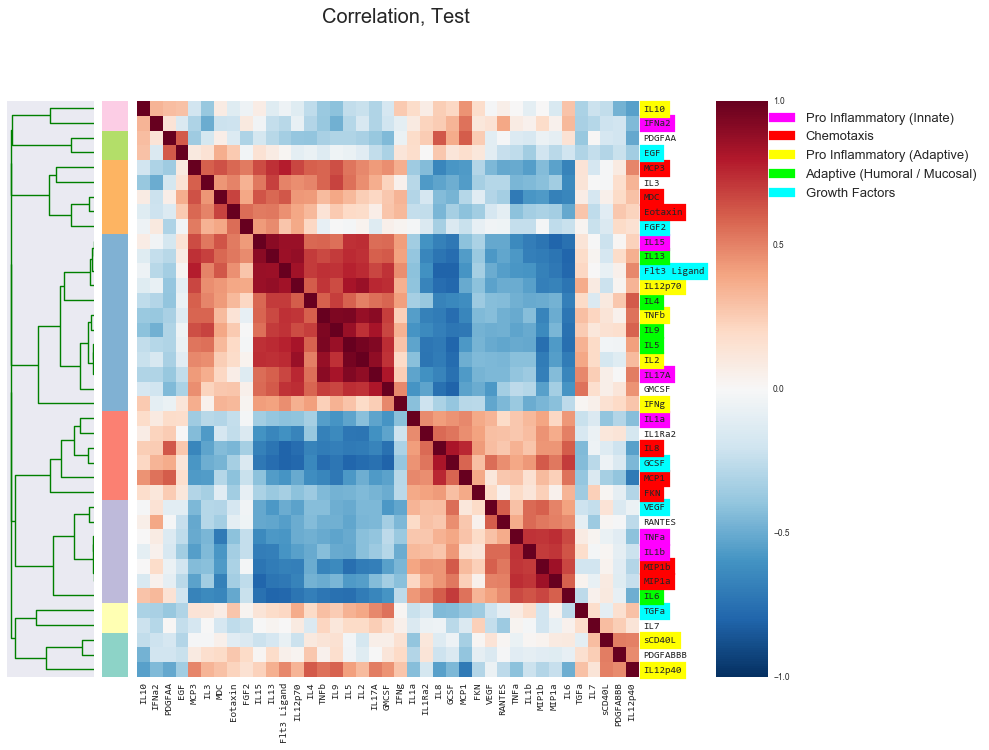

In [103]:
# plt.figure(43, figsize = (15.5, 9.5))
# colInds = plot.plotHierClust(1 - rcyc.pwrel,
#                                rcyc.Z,
#                                labels=rcyc.labels,
#                                titleStr='Pairwise reliability',
#                                vRange=(0, 1),
#                                tickSz='large')


def _colors2labels(labels, setStr = 'Set3', cmap = None):
    """Return pd.Series of colors based on labels"""
    if cmap is None:
        N = max(3, min(12, len(np.unique(labels))))
        cmap = palettable.colorbrewer.get_map(setStr, 'Qualitative', N).mpl_colors
    cmapLookup = {k:col for k, col in zip(sorted(np.unique(labels)), itertools.cycle(cmap))}
    return labels.map(cmapLookup.get)
def _clean_axis(ax):
    """Remove ticks, tick labels, and frame from axis"""
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    for sp in list(ax.spines.values()):
        sp.set_visible(False)
    ax.grid(False)
    # ax.set_axis_bgcolor('white')
def plotHierClust(dmatDf, Z, cmap, vRange, filename, savefile=False, labels=None, titleStr=None, tickSz= 10, cmapLabel=''):
    """Display a hierarchical clustering result."""
    
    vmin, vmax = vRange
    fig = plt.gcf()
    fig.clf()

    if labels is None:
        denAX = fig.add_subplot(GridSpec(1, 1, left=0.05, bottom=0.05, right=0.15, top=0.85)[0, 0])
        heatmapAX = fig.add_subplot(GridSpec(1, 1, left=0.16, bottom=0.05, right=0.78, top=0.85)[0, 0])
        scale_cbAX = fig.add_subplot(GridSpec(1, 1, left=0.87, bottom=0.05, right=0.93, top=0.85)[0, 0])
    else:
        denAX = fig.add_subplot(GridSpec(1, 1, left=0.05, bottom=0.05, right=0.15, top=0.85)[0, 0])
        cbAX = fig.add_subplot(GridSpec(1, 1, left=0.16, bottom=0.05, right=0.19, top=0.85)[0, 0])
        heatmapAX = fig.add_subplot(GridSpec(1, 1, left=0.2, bottom=0.05, right=0.78, top=0.85)[0, 0])
        scale_cbAX = fig.add_subplot(GridSpec(1, 1, left=0.87, bottom=0.05, right=0.93, top=0.85)[0, 0])

    my_norm = mpl.colors.Normalize(vmin = vmin, vmax = vmax)

    """Dendrogaram along the rows"""
    plt.sca(denAX)
    denD = sch.dendrogram(Z, p = 2, truncate_mode = 'none', color_threshold=np.inf, orientation='left')
    colInd = denD['leaves']
    _clean_axis(denAX)

    if not labels is None:
        cbSE = _colors2labels(labels)
        axi = cbAX.imshow([[x] for x in cbSE.iloc[colInd].values], interpolation='nearest', aspect='auto', origin='lower')
        
        _clean_axis(cbAX)

    """Heatmap plot"""
    axi = heatmapAX.imshow(dmatDf.values[colInd,:][:, colInd], interpolation='nearest', aspect='auto', origin='lower', norm=my_norm, cmap=cmap)
    _clean_axis(heatmapAX)

    """Column tick labels along the rows"""
    if tickSz is None:
        heatmapAX.set_yticks(())
        heatmapAX.set_xticks(())
    else:
        heatmapAX.set_yticks(np.arange(dmatDf.shape[1]))
        heatmapAX.yaxis.set_ticks_position('right')
        heatmapAX.set_yticklabels(dmatDf.columns[colInd], fontsize=tickSz, fontname='Consolas')

        """Column tick labels"""
        heatmapAX.set_xticks(np.arange(dmatDf.shape[1]))
        xlabelsL = heatmapAX.set_xticklabels(dmatDf.columns[colInd], fontsize=tickSz, rotation=90, fontname='Consolas')
        
    """Assign cytokines to groups and change their color on the y-axis"""
    pro_inflammatory_innate = ['IFNa2', 'IL15', 'IL17A', 'IL18', 'IL1a', 'IL1b', 'IP10', 'TNFa', 'IL-IRa']
    chemotaxis = ['Eotaxin', 'FKN', 'GRO', 'IL8', 'MCP1', 'MCP3', 'MDC', 'MIP1a', 'MIP1b']
    pro_inflammatory_adaptive = ['IFNg', 'IL2', 'IL10', 'IL12p40', 'IL12p70', 'sCD40L', 'TNFb']
    adaptive = ['IL4', 'IL5', 'IL6', 'IL9', 'IL13']
    growth_factors = ['EGF', 'FGF2', 'Flt3 Ligand', 'GCSF', 'TGFa', 'VEGF']

    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in pro_inflammatory_innate:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('magenta')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in chemotaxis:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('red')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in pro_inflammatory_adaptive:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('yellow')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in adaptive:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('lime')
    for i in range(0, len(heatmapAX.get_yticklabels())):
        if (heatmapAX.get_yticklabels()[i]).get_text() in growth_factors:
            heatmapAX.get_yticklabels()[i].set_backgroundcolor('cyan')
#     print(heatmapAX.get_yticklabels()[0].get_position())
    """Add Legend for Cytokine Groups"""
    pro_inflammatory_innate_legend = mpatches.Patch(color = 'magenta', label = 'Pro Inflammatory (Innate)')
    chemotaxis_legend = mpatches.Patch(color = 'red', label = 'Chemotaxis')
    pro_inflammatory_adaptive_legend = mpatches.Patch(color = 'yellow', label = 'Pro Inflammatory (Adaptive)')
    adaptive_legend = mpatches.Patch(color = 'lime', label = 'Adaptive (Humoral / Mucosal)')
    growth_factors_legend = mpatches.Patch(color = 'cyan', label = 'Growth Factors')
    heatmapAX.legend(handles = [pro_inflammatory_innate_legend, chemotaxis_legend, pro_inflammatory_adaptive_legend, adaptive_legend, growth_factors_legend], bbox_to_anchor = (1.7, 1), fontsize = 13)
    
#     plt.yticks(bbox = [[1, 0], [4, 3]])
    
#     mpatches.FancyBboxPatch((1, 0), 100, 4)
                
#         """Remove the tick lines"""
#         for l in heatmapAX.get_xticklines() + heatmapAX.get_yticklines(): 
#             l.set_markersize(0)

    """Add a colorbar"""
    cb = fig.colorbar(axi, scale_cbAX) # note that we could pass the norm explicitly with norm=my_norm
    cb.set_label(cmapLabel)
    cb.set_ticks([-1, -0.5, 0, 0.5, 1])

    """Make colorbar labels smaller"""
    for t in cb.ax.yaxis.get_ticklabels():
        t.set_fontsize('small')
    heatmapAX.xaxis.tick_bottom()
    heatmapAX.invert_xaxis()
    
    """Save Graph to Specified Path"""
    if titleStr:
        plt.suptitle(titleStr, fontsize = 20)
    if savefile:
        for file in os.listdir("./Flu09"):
            if file == filename+'.png':
                raise Exception('Directory already contains a file with this filename!')
            else:
                path = "./Flu09/"
                file_name = op.join(path, filename+'.png')
                plt.savefig(file_name, bbox_inches = 'tight')
                
                
    """Create and Save Data Table of Clusters and Cytokines"""
    if savfile:
        dict_1 = {}
        for i in range(len(rcyc.labels.index)):
            dict_1[rcyc.labels.index[i]] = rcyc.labels.values[i]

        sorted_by_value = sorted(dict_1.items(), key=lambda kv: kv[1])

        table = {}
        for tup in sorted_by_value:
            if tup[1] in table.keys():
                table[tup[1]] += (tup[0],)
            else:
                table[tup[1]] = (tup[0],)

        sorted_by_value_1 = sorted(table.items(), key=lambda kv: kv[1])

        new_table = []
        i = 1
        while i < len(sorted_by_value_1):
            for tup in sorted_by_value_1:
                if int(tup[0]) == i:
                    new_table += [tup]
                    i += 1
                else:
                    continue

        header = [('Cluster', 'Cytokines')]
        header += new_table

        t = Texttable()
        t.add_rows(header)

        text_file = open("Data Table -- {}".format(title_string), "w")
        text_file.write(t.draw())
        text_file.close()
        
        new_dict = {}
            for i in new_table:
                new_dict[i[0]] = i[1]

        text_file_1 = open("cluster_data.txt", "w")
        text_file_1.write(str(new_dict))
        text_file_1.close()
    
    
plt.figure(figsize = (12,10))



plotHierClust(rcyc.cyDf.corr(method="pearson", min_periods=1), 
              rcyc.Z, 
              filename = 'Correlation, {}'.format(title_string),
              cmap = palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap, 
              vRange = (-1, 1), labels = rcyc.labels, 
              titleStr = "Correlation, {}".format(title_string),
              savefile = save_file)



plotHierClust(1 - rcyc.pwrel,
                    cy.hierClusterFunc(rcyc.pwrel, returnLinkageMat=True, method = "complete")[1],
                    labels=rcyc.labels,
                    titleStr='{}'.format(title_string),
                    vRange=(0, 1),
                    cmap = cm.YlOrRd,
                    filename = '{}'.format(title_string),
                    savefile = save_file)

In [47]:
# print((rcyc.labels.index))
# print(rcyc.labels.values)
dict_1 = {}
for i in range(len(rcyc.labels.index)):
    dict_1[rcyc.labels.index[i]] = rcyc.labels.values[i]


sorted_by_value = sorted(dict_1.items(), key=lambda kv: kv[1])
# pprint.pprint(sorted_by_value)
# print(sorted_by_value[0][1])
table = {}

for tup in sorted_by_value:
    if tup[1] in table.keys():
        table[tup[1]] += (tup[0],)
    else:
        table[tup[1]] = (tup[0],)

sorted_by_value_1 = sorted(table.items(), key=lambda kv: kv[1])
new_table = []
i = 1
while i < len(sorted_by_value_1):
    for tup in sorted_by_value_1:
        if int(tup[0]) == i:
            new_table += [tup]
            i += 1
        else:
            continue

header = [('Cluster', 'Cytokines')]
header += new_table

t = Texttable()
t.add_rows(header)
print(t.draw())

text_file = open("Test Table.txt", "w")

text_file.write(t.draw())

text_file.close()

+---------+--------------------------------------------------------------------+
| Cluster |                             Cytokines                              |
+=========+====================================================================+
| 1       | ('IL12p40', 'PDGFABBB', 'sCD40L')                                  |
+---------+--------------------------------------------------------------------+
| 2       | ('IL7', 'TGFa')                                                    |
+---------+--------------------------------------------------------------------+
| 3       | ('IL1b', 'IL6', 'MIP1a', 'MIP1b', 'RANTES', 'TNFa', 'VEGF')        |
+---------+--------------------------------------------------------------------+
| 4       | ('FKN', 'GCSF', 'IL1Ra2', 'IL1a', 'IL8', 'MCP1')                   |
+---------+--------------------------------------------------------------------+
| 5       | ('Flt3 Ligand', 'GMCSF', 'IFNg', 'IL12p70', 'IL13', 'IL15',        |
|         | 'IL17A', 'IL2', 

In [223]:
new_dict = {}
for i in new_table:
    new_dict[i[0]] = i[1]

text_file_1 = open("cluster_data.txt", "w")
text_file_1.write(str(new_dict))
text_file_1.close()

{1: ('IL12p40', 'PDGFABBB', 'sCD40L'), 2: ('IL7', 'TGFa'), 3: ('IL1b', 'IL6', 'MIP1a', 'MIP1b', 'RANTES', 'TNFa', 'VEGF'), 4: ('FKN', 'GCSF', 'IL1Ra2', 'IL1a', 'IL8', 'MCP1'), 5: ('Flt3 Ligand', 'GMCSF', 'IFNg', 'IL12p70', 'IL13', 'IL15', 'IL17A', 'IL2', 'IL4', 'IL5', 'IL9', 'TNFb'), 6: ('Eotaxin', 'FGF2', 'IL3', 'MCP3', 'MDC'), 7: ('EGF', 'PDGFAA'), 8: ('IFNa2', 'IL10')}


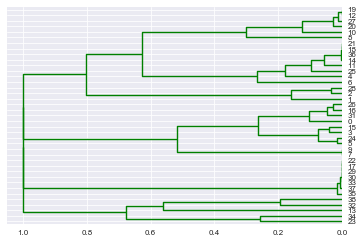

In [15]:
denD = sch.dendrogram(cy.hierClusterFunc(rcyc.pwrel, returnLinkageMat=True, method = "complete")[1], p = 2, truncate_mode = 'none', color_threshold=np.inf, orientation='left')
colInd = denD['leaves']


<Figure size 864x720 with 0 Axes>

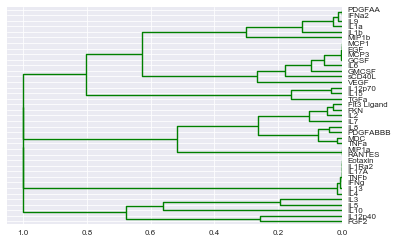

<Figure size 864x720 with 0 Axes>

In [22]:
denD_1 = sch.dendrogram(cy.hierClusterFunc(rcyc.pwrel, returnLinkageMat=True, method = "complete")[1], p = 2, truncate_mode = 'none', color_threshold=np.inf, orientation='left', labels = rcyc.pwrel.columns[colInd])
plt.savefig('Dendrogram_test.png', bbox_inches = 'tight')
plt.figure(figsize = (12, 10))


In [36]:
def moduleCorrRatio(cyDf, labels, cyVars=None, alpha=0.05, nstraps=10000):
    """Compute all pairwise intra- and inter-module cytokine correlation
    coefficients with their IQRs.

    Additionally compute the intra : inter ratio with 95% CI, where the
    ratio is of signed-pearson correlation coefficients transformed to
    the [0,1] interval with 0 meaning perfect anti-correlation
    and 1 meaning perfect correlation
    
    For ratio, uses a signed Pearson correlation coefficient since this is what is used
    for clustering. The disadvantage is that it can't be described as fractional
    variance, while the upside is that it captures the potential problem with
    forming modules of anti-correlated cytokines.

    Parameters
    ----------
    cyDf : pd.DataFrame [n_participants x n_cytokines]
        Raw or normalized analyte log-concentrations.
    labels : pd.Series
        Module labels for each analyte

    Returns
    -------
    intra : np.ndarray shape (3,)
        Vector containing 25th, 50th and 75th quantiles of all cytokine pairs within the same module.
    inter : np.ndarray shape (3,)
        Vector containing 25th, 50th and 75th quantiles of all cytokine pairs from different modules.
    ratio : np.ndarray shape (3,)
        Vector containing the intra : inter correlation ratio with bootstrap 95% CI or (1 - alpha)%
        [LB, ratio, UB]"""

    def ratioFunc(cyDf, intraMask, interMask):
        """smat is on the [0, 1] interval with 0 meaning perfect anti-correlation and 1 meaning perfect correlation"""
        smat = 1 - cy.corrDmatFunc(cyDf, metric='pearson-signed').values
        return np.nanmean((smat * intraMask).ravel()) / np.nanmean((smat * interMask).ravel())

    if cyVars is None:
        cyVars = cyDf.columns.tolist()

    """corrmat is on the [-1, 1] interval with 1 meaning perfect correlation and -1 meaning perfect anti-correlation"""
    corrmat = cyDf[cyVars].corr()

    intra = []
    inter = []
    intraMask = np.nan * np.zeros(corrmat.shape)
    interMask = np.nan * np.zeros(corrmat.shape)
    for a, b in itertools.combinations(cyVars, 2):
        if not a == b:
            s = corrmat.loc[a, b]
            i, j = cyVars.index(a), cyVars.index(b)
            if labels[a] == labels[b]:
                intra.append(s)
                intraMask[i, j] = 1.
            else:
                inter.append(s)
                interMask[i, j] = 1.

    intra = np.percentile(intra, q=[25, 50, 75])
    inter = np.percentile(inter, q=[25, 50, 75])

    if nstraps is None or nstraps == 0:
        return intra, inter
    
    else:
        rratios = np.zeros(nstraps)
        for strapi in range(nstraps):
            rratios[strapi] = ratioFunc(cyDf[cyVars].sample(frac=1, replace=True, axis=0), intraMask, interMask)
        ratio = np.percentile(rratios, [100*alpha/2, 50, 100*(1-alpha/2)])

        return intra, inter, ratio
    
moduleCorrRatio(rcyc.cyDf, rcyc.labels)




(array([0.67302865, 0.72879529, 0.75796345]),
 array([-0.32475297, -0.08132901,  0.20493475]),
 array([1.79575341, 1.82990487, 1.85973399]))

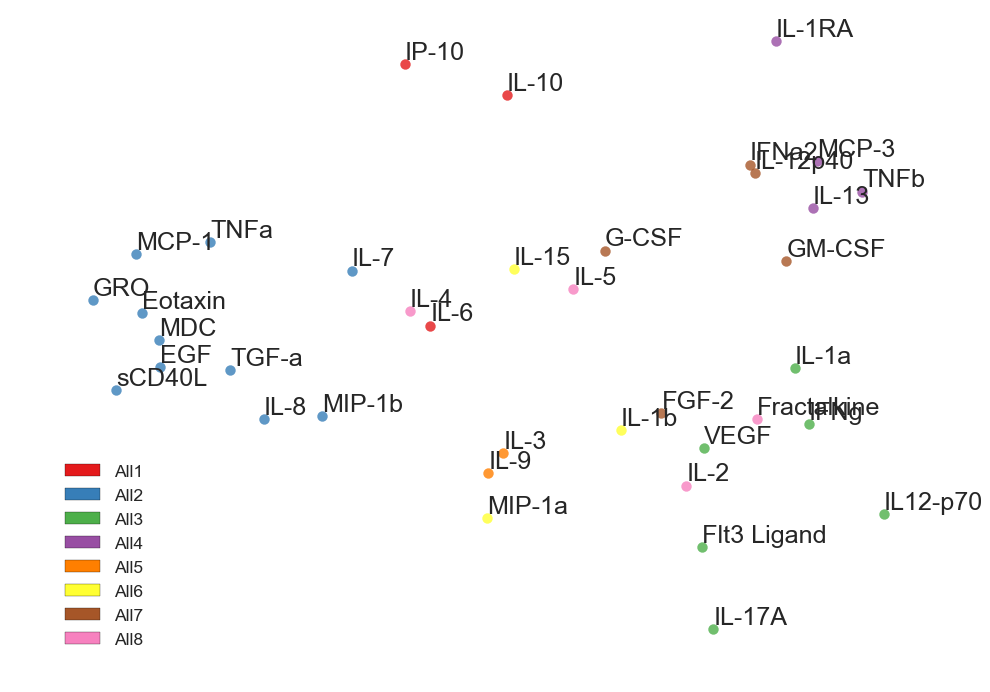

In [549]:
plt.figure(901, figsize=(13, 9.7))
plot.plotModuleEmbedding(rcyc.dmatDf, rcyc.labels, method='kpca', txtSize='large')
colors = palettable.colorbrewer.get_map('Set1', 'qualitative', len(np.unique(rcyc.labels))).mpl_colors
colorLegend(colors, ['%s%1.0f' % (rcyc.sampleStr, i) for i in np.unique(rcyc.labels)], loc='lower left')


In [15]:
import scipy.stats

"""df here should have one column per module and the genotype column"""
ptidDf = longDf[['ptid', 'sample', 'genotype', 'dpi']].drop_duplicates().set_index('ptid')
df = rcyc.modDf.join(ptidDf)

ind = df.genotype == 'WT'
col = 'LUNG1'
# stats.ranksums(df[col].loc[ind], df[col].loc[~ind])


